In [ ]:
# LSTMABAR: Single Configuration Training Pipeline
## Configuration: Quantum 8-Qubit (High Regularization)

# This notebook trains a specific configuration of the LSTMABAR model using Contrastive Learning.
# It focuses on aligning the Text Tower and Audio Tower embeddings.

# **Target Configuration:** `quantum_8qubit_depth3_high_reg`

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import time
import matplotlib.pyplot as plt

from lstmabar_model import LSTMABAR
from text_tower import TextEncoder
from audio_tower import AudioEncoder
from contrastive_alignment import ContrastiveAlignmentModule
from musiccaps_loader import MusicCapsLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
config = {
    'name': 'quantum_8qubit_depth3_high_reg',
    'embedding_dim': 768,
    'audio_architecture': 'resnet',
    'batch_size': 16,
    'learning_rate': 5e-05,
    'num_epochs': 15,
    'use_quantum_attention': True,
    'n_qubits': 8,
    'circuit_depth': 3,
    'dropout_rate': 0.4,
    'noise_strength': 0.15
}

print("Training Configuration Loaded:")
print(json.dumps(config, indent=2))

Training Configuration Loaded:
{
  "name": "quantum_8qubit_depth3_high_reg",
  "embedding_dim": 768,
  "audio_architecture": "resnet",
  "batch_size": 16,
  "learning_rate": 5e-05,
  "num_epochs": 15,
  "use_quantum_attention": true,
  "n_qubits": 8,
  "circuit_depth": 3,
  "dropout_rate": 0.4,
  "noise_strength": 0.15
}


In [9]:

class MusicCapsDataset(Dataset):
    """
    PyTorch Dataset for MusicCaps designed for Contrastive Learning.
    """
    
    def __init__(
        self,
        training_data_path: str,
        sample_rate: int = 44100,
        audio_duration: float = 2.0,
        augment: bool = False
    ):
        """
        Args:
            training_data_path: Path to .npz file with training data
            sample_rate: Audio sample rate
            audio_duration: Duration to load from each audio file
            augment: Whether to apply data augmentation
        """
        self.sample_rate = sample_rate
        self.audio_duration = audio_duration
        self.augment = augment
        self.target_samples = int(sample_rate * audio_duration)
        
        # Load training data
        print(f"Loading training data from {training_data_path}")
        data = np.load(training_data_path, allow_pickle=True)
        
        self.descriptions = data['descriptions'].tolist()
        self.audio_paths = data['audio_paths'].tolist()
        
        # NOTE: We load archetype vectors if present, but for Contrastive Pre-training
        # we don't strictly need them. We keep them for potential future use.
        if 'archetype_vectors' in data:
            self.archetype_vectors = torch.from_numpy(data['archetype_vectors']).float()
        else:
            self.archetype_vectors = None
        
        print(f"Loaded {len(self.descriptions)} training examples")
        
        # Filter out samples with missing audio files
        self.valid_indices = self._find_valid_samples()
        print(f"Found {len(self.valid_indices)} samples with valid audio files")
    
    def _find_valid_samples(self) -> List[int]:
        """Find indices with existing audio files"""
        valid = []
        for i, audio_path in enumerate(self.audio_paths):
            if Path(audio_path).exists():
                valid.append(i)
        return valid
    
    def __len__(self) -> int:
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Dict:
        """
        Get a single training sample
        Returns dict with 'audio' (Tensor) and 'text' (str)
        """
        # Map to valid index
        actual_idx = self.valid_indices[idx]
        
        # Load audio
        audio_path = self.audio_paths[actual_idx]
        
        try:
            # Use librosa to load (resamples automatically)
            audio, sr = librosa.load(
                audio_path,
                sr=self.sample_rate,
                duration=self.audio_duration
            )
        except Exception as e:
            # Fallback for corrupted files (return silence)
            print(f"Error loading {audio_path}: {e}")
            audio = np.zeros(self.target_samples)

        # Pad or trim to exact length
        if len(audio) < self.target_samples:
            audio = np.pad(audio, (0, self.target_samples - len(audio)))
        else:
            audio = audio[:self.target_samples]
        
        # Apply augmentation if enabled
        if self.augment:
            audio = self._augment_audio(audio)
        
        # Convert to tensor [1, Samples] for ResNet compatibility (if needed)
        # or [Samples] depending on your AudioEncoder. 
        # Usually AudioEncoder expects [Batch, Samples], so here we return [Samples]
        audio_tensor = torch.from_numpy(audio).float()
        
        # Get description
        text = self.descriptions[actual_idx]
        
        item = {
            'audio': audio_tensor,
            'text': text  # Changed from 'description' to 'text' for pipeline compatibility
        }
        
        return item
    
    def _augment_audio(self, audio: np.ndarray) -> np.ndarray:
        """Apply random audio augmentations"""
        # Random gain (±3dB)
        if np.random.random() > 0.5:
            gain_db = np.random.uniform(-3, 3)
            audio = audio * (10 ** (gain_db / 20))
        
        # Random time shift (circular)
        if np.random.random() > 0.5:
            shift = np.random.randint(-self.sample_rate // 10, self.sample_rate // 10)
            audio = np.roll(audio, shift)
        
        # Add slight noise
        if np.random.random() > 0.5:
            noise = np.random.randn(len(audio)) * 0.005
            audio = audio + noise
        
        return audio

def collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function for DataLoader
    """
    # Stack audio: [Batch, Samples]
    audio = torch.stack([item['audio'] for item in batch])
    
    # List of text strings (cannot be stacked as tensors)
    texts = [item['text'] for item in batch]
    
    return {
        'audio': audio,
        'text': texts
    }

In [10]:
def prepare_musiccaps_data(
    csv_path: str,
    audio_dir: str = 'musiccaps_audio',
    output_path: str = 'musiccaps_training_data.npz',
    max_downloads: int = 500,
    train_split: float = 0.7,
    val_split: float = 0.15,
    test_split: float = 0.15,
    random_seed: int = 42
) -> Tuple[str, str, str]: # Returns 3 paths
    """
    Prepare MusicCaps dataset for training
    """
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, "Splits must sum to 1.0"

    print("=== Preparing MusicCaps Dataset ===")
    
    # NOTE: Ensure MusicCapsLoader is imported/available here
    # from scripts.data_loader import MusicCapsLoader 
    loader = MusicCapsLoader(csv_path, audio_dir)
    
    # Download audio clips
    print(f"\nDownloading up to {max_downloads} audio clips...")
    downloaded, failed = loader.download_audio_clips(
        max_clips=max_downloads,
        use_balanced_subset=True
    )
    
    print(f"Successfully downloaded: {len(downloaded)}")
    print(f"Failed: {len(failed)}")
    
    # Create archetype training data (We keep this for metadata, even if we use Contrastive)
    print("\nProcessing metadata...")
    # Using TF-IDF weighting if your loader supports it
    training_data = loader.create_archetype_training_data(use_tfidf_weighting=True)
    
    # Shuffle
    np.random.seed(random_seed)
    indices = np.random.permutation(len(training_data))
    training_data = [training_data[i] for i in indices]
    
    # Split
    n_total = len(training_data)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)
    
    train_data = training_data[:n_train]
    val_data = training_data[n_train:n_train + n_val]
    test_data = training_data[n_train + n_val:]
    
    print(f"\nDataset split: Train({len(train_data)}) Val({len(val_data)}) Test({len(test_data)})")
    
    # Helper to save NPZ
    def save_split(data, suffix):
        path = output_path.replace('.npz', f'_{suffix}.npz')
        
        vectors = np.array([item['archetype_vector'] for item in data])
        descriptions = [item['description'] for item in data]
        audio_paths = [item['audio_path'] for item in data]
        
        # Save
        np.savez_compressed(
            path,
            archetype_vectors=vectors,
            descriptions=descriptions,
            audio_paths=audio_paths
        )
        print(f"✓ Saved {suffix} set: {path}")
        return path

    train_path = save_split(train_data, 'train')
    val_path = save_split(val_data, 'val')
    test_path = save_split(test_data, 'test')
    
    return train_path, val_path, test_path

In [11]:
import torch
import kagglehub
from torch.utils.data import DataLoader

In [12]:
# --- STEP 1: PREPARE DATA ---

# Download latest version from Kaggle
path = kagglehub.dataset_download("googleai/musiccaps")
csv_path = f"{path}/musiccaps-public.csv"
print(f"Dataset CSV at: {csv_path}")

# Run preparation (Downloads audio if needed)
train_data_path, val_data_path, test_data_path = prepare_musiccaps_data(
    csv_path=csv_path,
    audio_dir='musiccaps_audio',
    max_downloads=config.get('batch_size', 16) * 20, # Download enough for a few epochs
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    random_seed=42
)

Dataset CSV at: /Users/shanthgopalswamy/.cache/kagglehub/datasets/googleai/musiccaps/versions/1/musiccaps-public.csv
=== Preparing MusicCaps Dataset ===
Loaded 5521 MusicCaps examples

Using balanced subset: 1000 examples
✓ Already exists: -bgHkxwoliw
✓ Already exists: -kpR93atgd8
✓ Already exists: -wymN80CiYU
✓ Already exists: 07xGXxIHOL4
✓ Already exists: 0PMFAO4TIU4
✓ Already exists: 0TV9zvfwFhs
✓ Already exists: 0fiOM---7QI


ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited


Error downloading 0i8VM_EooCs: ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited
✗ Failed: 0i8VM_EooCs
✓ Already exists: 0jFQ21A6GRA
✓ Already exists: 1ACn3u5UnBw
✓ Already exists: 1BVSYfNCcv0
✓ Already exists: 1JpeDWbgUO8
✓ Already exists: 1PKxdTlquCA
✓ Already exists: 1Q9DXhXMSFI
✓ Already exists: 1TyOPtg0Yfk
✓ Already exists: 1V7ReAk9k-4
✓ Already exists: 1j4rFfU5XKQ
✓ Already exists: 20Vh6z6Ie0E


ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 2G5bSYHcJSM: ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 2G5bSYHcJSM
✓ Already exists: 2GWkKVHxGRM
✓ Already exists: 2JnlmS1zzls
✓ Already exists: 2RU4CSDzS-g
✓ Already exists: 2U8Dvh7nwFI
✓ Already exists: 2ZfthfWQowE
✓ Already exists: 2bCuw7U_Rac
✓ Already exists: 2dyEnOo3yJ8
✓ Already exists: 2vQTq4QLP8U
✓ Already exists: 2xGRCsW6-Bk
✓ Already exists: 3JYQgXudiH8
✓ Already exists: 3TQmts_MxyQ
✓ Already exists: 40D4L5Ndi6k
✓ Already exists: 44sbWBFswUY
✓ Already exists: 4i11P4OCRfk
✓ Already exists: 5JQIsqc8HBc
✓ Already exists: 5XXAeSybGK0
✓ Already exists: 5ZpVhmhVYoI
✓ Already exists: 5_orEetudIA
✓ Already exists: 5gyMt0YzPQ0
✓ Already exists: 60OIHit4Q-M
✓ Already exists: 6N1LWG4aztA
✓ Already exists: 6k4lcF9IGUk
✓ Already exists: 7-mNJ4IUY5Q
✓ Already exists: 7WZwlOrRELI
✓ Already exists: 7_q36NyJtQY
✓ Already exists: 8BJljuSm2Aw
✓ Alread

ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe


Error downloading BXo1Tr_oJds: ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe
✗ Failed: BXo1Tr_oJds
✓ Already exists: Bl-lCgr5hGY
✓ Already exists: BnkDQXlrIX4
✓ Already exists: Byk9p21g51g
✓ Already exists: C5MhO2HM2Wg
✓ Already exists: C6roSYqchkk
✓ Already exists: C8VECv8kicU
✓ Already exists: CJjyrDGmxIY
✓ Already exists: CP3phqztym0
✓ Already exists: CRxIJ7YbcZA
✓ Already exists: CWQvCCRuU6k
✓ Already exists: CZuH43NPynA
✓ Already exists: Cchf2QH63bI
✓ Already exists: ChyayWIp_vU
✓ Already exists: CphwhKgYHaM
✓ Already exists: CzMNiypg1I8


ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni


Error downloading Czbi1u-gwUU: ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni
✗ Failed: Czbi1u-gwUU
✓ Already exists: D2w3qHmJrdU
✓ Already exists: D3FyfFIKLVc
✓ Already exists: D4ccFYk3bhU


ERROR: [youtube] D8-x1T8M4gk: Video unavailable


Error downloading D8-x1T8M4gk: ERROR: [youtube] D8-x1T8M4gk: Video unavailable
✗ Failed: D8-x1T8M4gk
✓ Already exists: DAPGvg8qOAU
✓ Already exists: DCFrCX4HPO8
✓ Already exists: DG5d4megH8g
✓ Already exists: DGbMEkQerYs
✓ Already exists: DKflAAykh6A
✓ Already exists: DP2vmsftZHY
✓ Already exists: DU5pD63Pv30
✓ Already exists: DaiVfxATCEE
✓ Already exists: DdxW_JziHTA


ERROR: [youtube] DysXetu2I0E: Video unavailable


Error downloading DysXetu2I0E: ERROR: [youtube] DysXetu2I0E: Video unavailable
✗ Failed: DysXetu2I0E
✓ Already exists: EKZvq0dUk50
✓ Already exists: EUNTykrvpok
✓ Already exists: EaGhKzpkNso


ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading EfUUgsioXyU: ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: EfUUgsioXyU
✓ Already exists: EmSZKb0LdVM
✓ Already exists: Es9FNjZ-SHI
✓ Already exists: FCzMqo8kh1o
✓ Already exists: FDO5BekX478
✓ Already exists: FENJIDecy5s
✓ Already exists: Fsm-xDmyFKg
✓ Already exists: FsnRM2irjvI
✓ Already exists: FteW_2gNtD4


ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Fv9swdLA-lo: ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Fv9swdLA-lo
✓ Already exists: G2uCAwYS6w0
✓ Already exists: GHQlBD-6rkA
✓ Already exists: GJYhDjThTHM
✓ Already exists: GLIXnXZEOxY
✓ Already exists: GPSqrciDLog
✓ Already exists: GQbUpJFArKI
✓ Already exists: GYCfrx0ruz4
✓ Already exists: GbjtSTTEFK4
✓ Already exists: Gc8xf7CJiFY
✓ Already exists: GkB_BkyVyPs
✓ Already exists: Guu30szkA-0
✓ Already exists: H6qzijVEqZQ
✓ Already exists: HFH9tcIK_PM
✓ Already exists: HFVM5pVTwkM
✓ Already exists: HHTgjmgTV6c
✓ Already exists: HNf9eHqDT1A
✓ Already exists: HS_ikHx4LIQ
✓ Already exists: HU7oqkJeItQ
✓ Already exists: HYjSrwSm0T4
✓ Already exists: HfzEa06vDLg
✓ Already exists: Hg4f2xt3oKA
✓ Already exists: HkXSX7Kdhms
✓ Already exists: Hnk45Z0EAxg
✓ Already exists: HzXWXYxXyYA
✓ Already exists: ID4AoAfHMVk
✓ Already exists: IKq2OF8jq1c
✓ Alread

ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading LRfVQsnaVQE: ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: LRfVQsnaVQE
✓ Already exists: L_nC2BvhRdQ
✓ Already exists: LfvdxSBCtFE
✓ Already exists: LjihfG0fit0
✓ Already exists: LybSS4amIS0
✓ Already exists: LzSWdj4izHM
✓ Already exists: MHkfPjW0aRg
✓ Already exists: MIexFfOsuJs
✓ Already exists: MKikHxKeodA
✓ Already exists: MM0seezR2F4
✓ Already exists: MVYSWTF11Nc
✓ Already exists: MY0PsDE3xHs
✓ Already exists: MdYXznF3Eac
✓ Already exists: MpWGx5odhh8
✓ Already exists: MsjeOXuUYG4
✓ Already exists: MvnC1TfNiPY
✓ Already exists: MzUgHy7SyS8
✓ Already exists: N-dzfI3L5ic
✓ Already exists: NHA1l_Czm38
✓ Already exists: N_Wx35sNqdM
✓ Already exists: NlCfScKw_Mk
✓ Already exists: NsYVaRI6rXg
✓ Already exists: Nt0U-CXK6O0
✓ Already exists: NwA9JSlK_lM
✓ Already exists: O1RmrE_HfpE
✓ Already exists: OB7GyVqufwQ
✓ Already exists: OEjgIDubFbg
✓ Alread

ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir


Error downloading T6iv9GFIVyU: ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir
✗ Failed: T6iv9GFIVyU
✓ Already exists: T7A0RejsZIo
✓ Already exists: T7ZSZhcsfjA
✓ Already exists: TN53jpjqAGI
✓ Already exists: TPYNIc_M1ng
✓ Already exists: Tp8PG2xae8c
✓ Already exists: Tsmx6Pb7CnU
✓ Already exists: TworrkXAPuI
✓ Already exists: TzPuAqjoL80
✓ Already exists: U4UtZeTl2DE
✓ Already exists: UDN11Q90Fa4
✓ Already exists: UFyOGqmITjM
✓ Already exists: UIOnnpaqBy8
✓ Already exists: UNJswfXKJ3s
✓ Already exists: UQKLBsZJsww
✓ Already exists: UcabTrKowlI
✓ Already exists: UnFEqUWTefM
✓ Already exists: UoxHwOl2gN0
✓ Already exists: UrgzGbGVV8I
✓ Already exists: UsdoUjuczY4
✓ Already exists: UtZofZjccBs
✓ Already exists: UvCY9FHpKC8
✓ Already exists: V3Vvp5HS90k
✓ Already exists: V9jIsOTC1lY
✓ Already exists: VCusyLPrFCo
✓ Already exists: VG6-MlmCgzI
✓ Already exists: VHYxygh1STA
✓ Already exists: VL6uF-XeE_A
✓ Already exi

ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading W0aT3SdtnfY: ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: W0aT3SdtnfY
✓ Already exists: W3lKc2hj4XU
✓ Already exists: W7U-glgu4GM
✓ Already exists: WCifI6rwOoM
✓ Already exists: WEVBqGarEIY
✓ Already exists: WMtztIW1f6k
✓ Already exists: WPguqXCBQCI
✓ Already exists: WTVC7ZI9WtY
✓ Already exists: WT_wvvEvkw4
✓ Already exists: WaddbqEQ1NE


ERROR: [youtube] We0WIPYrtRE: Video unavailable


Error downloading We0WIPYrtRE: ERROR: [youtube] We0WIPYrtRE: Video unavailable
✗ Failed: We0WIPYrtRE
✓ Already exists: WeDA1mDFSCo
✓ Already exists: WgZ8KAnnTb8
✓ Already exists: WsDb16qzA5Q
✓ Already exists: WtN6uiDikRM
✓ Already exists: X96v9LlsjJM
✓ Already exists: XE4NRSDLYG8
✓ Already exists: XUD-9HkQuTE
✓ Already exists: XXBVsNt2Qr8
✓ Already exists: XYOnq7ju7o0
✓ Already exists: XgOA5oRkL2A
✓ Already exists: XjUmXwVlDDo
✓ Already exists: XkBXsaSXDJ0


ERROR: [youtube] XvtL_TTLXHY: Video unavailable


Error downloading XvtL_TTLXHY: ERROR: [youtube] XvtL_TTLXHY: Video unavailable
✗ Failed: XvtL_TTLXHY
✓ Already exists: XwhAoMLNYWQ
✓ Already exists: XykUpCigu4w
✓ Already exists: Y7mTjfgcybQ
✓ Already exists: YZx0_GRtvJk
✓ Already exists: YcWJUHWt-64
✓ Already exists: YrGQKTbiG1g
✓ Already exists: YzpzKyzyL0Y
✓ Already exists: Z31gI08SMzI
✓ Already exists: Z7V7Curou7s
✓ Already exists: Z8L3jychP14
✓ Already exists: ZEuY5HnECuo
✓ Already exists: ZFimyfPWltk
✓ Already exists: ZJHlHb-VyDc
✓ Already exists: ZLXW4ewrVpQ
✓ Already exists: ZMd8mAKe-k8
✓ Already exists: ZNGvyFsCx4g
✓ Already exists: ZUcHBeueBww
✓ Already exists: ZUkh168Nyus
✓ Already exists: ZaUaqnLdg6k
✓ Already exists: Zhurw43-Y1g
✓ Already exists: ZkfKOLp5SxU
✓ Already exists: Zlbo8ygfPSM
✓ Already exists: ZmgkpmzvL6c

=== Download Summary ===
Successfully downloaded: 307
Failed: 13
Successfully downloaded: 307
Failed: 13

Processing metadata...

=== Archetype Distribution Statistics ===

SINE:
  Mean weight: 0.431
  Std de

In [13]:
# --- STEP 2: CREATE DATALOADERS ---

print("Creating PyTorch datasets...")

# Train Set (With Augmentation)
train_dataset = MusicCapsDataset(
    train_data_path,
    sample_rate=config.get('sample_rate', 44100),
    audio_duration=2.0, # Short clips for training speed
    augment=True
)

# Val Set (No Augmentation)
val_dataset = MusicCapsDataset(
    val_data_path,
    sample_rate=config.get('sample_rate', 44100),
    audio_duration=2.0,
    augment=False
)

# Create Loaders (CRITICAL: Pass collate_fn)
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True,
    collate_fn=collate_fn, # Handles list of strings
    num_workers=0 # Set to 2 or 4 if on Linux/Mac
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"Loaders Ready: {len(train_loader)} train batches, {len(val_loader)} val batches.")

Creating PyTorch datasets...
Loading training data from musiccaps_training_data_train.npz
Loaded 333 training examples
Found 333 samples with valid audio files
Loading training data from musiccaps_training_data_val.npz
Loaded 71 training examples
Found 71 samples with valid audio files
Loaders Ready: 21 train batches, 5 val batches.


In [17]:
class TrainingPipeline:
    def __init__(self, model, train_loader, val_loader, learning_rate=1e-4, device='cpu'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        trainable_params = [
            {'params': model.text_encoder.parameters()},
            {'params': model.audio_encoder.parameters()},
            {'params': model.contrastive_aligner.parameters()}
        ]
        
        self.optimizer = optim.AdamW(trainable_params, lr=learning_rate)
        
        self.history = {
            'train_loss': [], 
            'val_loss': [],
            'contrastive_loss': []
        }

    def _ensure_tensor(self, emb):
        """Helper to unpack tuples if encoders return (emb, extra_info)"""
        if isinstance(emb, tuple):
            return emb[0]
        return emb

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        contrastive_loss_accum = 0
        
        for batch_idx, batch in enumerate(self.train_loader):
            audio = batch['audio'].to(self.device)
            text = batch['text']
            
            self.optimizer.zero_grad()
            
            # Forward Pass
            outputs = self.model(text, audio, generate_audio=False)
            
            # *** FIX: Ensure we have tensors, not tuples ***
            text_emb = self._ensure_tensor(outputs['text_emb'])
            audio_emb = self._ensure_tensor(outputs['audio_emb'])
            
            # Calculate Loss
            loss, _ = self.model.contrastive_aligner(text_emb, audio_emb)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            contrastive_loss_accum += loss.item()
            
        avg_loss = total_loss / len(self.train_loader)
        self.history['train_loss'].append(avg_loss)
        self.history['contrastive_loss'].append(contrastive_loss_accum / len(self.train_loader))
        
        return avg_loss

    def validate(self):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in self.val_loader:
                audio = batch['audio'].to(self.device)
                text = batch['text']
                
                outputs = self.model(text, audio, generate_audio=False)
                
                # *** FIX: Ensure we have tensors, not tuples ***
                text_emb = self._ensure_tensor(outputs['text_emb'])
                audio_emb = self._ensure_tensor(outputs['audio_emb'])
                
                loss, _ = self.model.contrastive_aligner(text_emb, audio_emb)
                
                total_loss += loss.item()
                
        avg_loss = total_loss / len(self.val_loader)
        self.history['val_loss'].append(avg_loss)
        
        return avg_loss

    def save_checkpoint(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'config': config
        }, path)
        print(f"Checkpoint saved to {path}")

In [18]:
# --- INITIALIZE MODEL ---

print("Initializing LSTMABAR Model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    text_model='sentence-transformers/all-MiniLM-L6-v2',
    audio_architecture=config['audio_architecture'],
    sample_rate=44100,
    use_quantum_attention=config['use_quantum_attention'],
    n_qubits=config['n_qubits'],
    device=device
)

# Apply Quantum Specific settings if needed (Dropout/Noise)
# Assuming your TextEncoder handles these args internally or via setter
if hasattr(model.text_encoder, 'dropout'):
    model.text_encoder.dropout.p = config['dropout_rate']

print(f"Model initialized on {device}")

Initializing LSTMABAR Model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
🧠 Initializing Macro Archetype Predictor...
Translation Layer: Parameter Decoder...
🎹 Initializing Harmonic DDSP Engine...
Model initialized on cpu


In [19]:
# --- START TRAINING ---

pipeline = TrainingPipeline(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=config['learning_rate'],
    device=device
)

print(f"Starting training for {config['num_epochs']} epochs...")
start_time = time.time()

for epoch in range(config['num_epochs']):
    epoch_start = time.time()
    
    # Train
    train_loss = pipeline.train_epoch()
    
    # Validate
    val_loss = pipeline.validate()
    
    # Log
    duration = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{config['num_epochs']} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Time: {duration:.1f}s")
    
    # Save Best Model
    if epoch == 0 or val_loss < min(pipeline.history['val_loss'][:-1]):
        pipeline.save_checkpoint(f"checkpoints/{config['name']}_best.pth")

total_time = (time.time() - start_time) / 60
print(f"\nTraining Complete! Total time: {total_time:.2f} minutes")

Starting training for 15 epochs...
Epoch 1/15 | Train Loss: 2.7754 | Val Loss: 2.6105 | Time: 36.5s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 2/15 | Train Loss: 2.7004 | Val Loss: 2.5702 | Time: 35.3s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 3/15 | Train Loss: 2.6438 | Val Loss: 2.5331 | Time: 39.9s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 4/15 | Train Loss: 2.5684 | Val Loss: 2.4985 | Time: 42.3s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 5/15 | Train Loss: 2.4354 | Val Loss: 2.4492 | Time: 36.9s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 6/15 | Train Loss: 2.2708 | Val Loss: 2.4204 | Time: 37.6s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 7/15 | Train Loss: 1.9933 | Val Loss: 2.3663 | Time: 35.7s
Checkpoint saved to checkpoints/quantum_8qubit_depth3_high_reg_best.pth
Epoch 

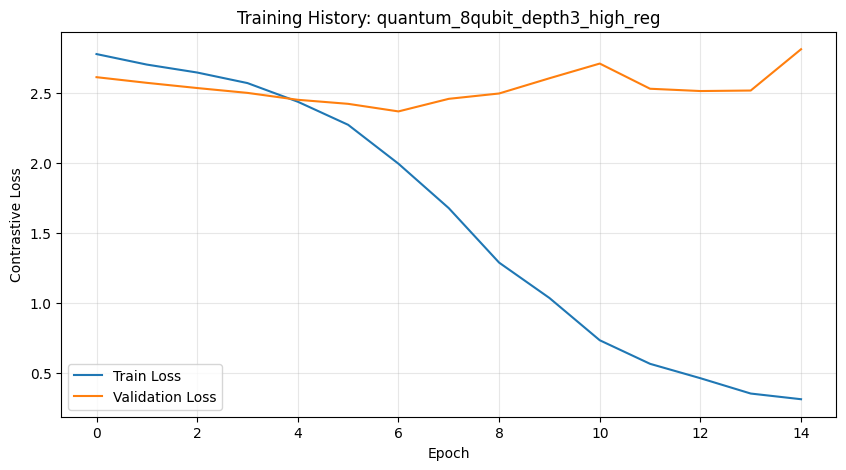

In [20]:
# --- VISUALIZATION ---

plt.figure(figsize=(10, 5))
plt.plot(pipeline.history['train_loss'], label='Train Loss')
plt.plot(pipeline.history['val_loss'], label='Validation Loss')
plt.title(f"Training History: {config['name']}")
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()